# Random Forest Regressor for RUL Prediction

## 📌 Summary of Work: 

## 🔧 1. Input Data

This project uses sensor data from turbofan engines to predict the **Remaining Useful Life (RUL)** using a **Random Forest Regressor**. The dataset comes from the **CMAPSS (Commercial Modular Aero-Propulsion System Simulation)** package, specifically four training files (`train_FD001.txt` to `train_FD004.txt`), each representing different operating conditions.

Each engine unit has:
- Engine ID
- Time in cycles
- 3 operational settings
- 21 sensor measurements over time

The goal is to build a model that estimates how many cycles remain before engine failure based on these features.

---

## 🧹 2. Preprocessing

Several preprocessing steps were applied:

- **Column Naming**: Columns were renamed for clarity (e.g., `sensor_1`, `op_setting_2`).
- **Data Loading & Merging**: All four datasets were loaded, cleaned, and combined into a single DataFrame for unified processing.
- **RUL Calculation**: For each engine, RUL was computed as the difference between the maximum cycle count and current cycle.
- **Feature Selection**: Less informative or constant-value columns were removed manually:
  - `'op_setting_3'`
  - `'sensor_1'`, `'sensor_5'`, `'sensor_10'`, `'sensor_16'`, `'sensor_18'`, `'sensor_19'`
- **Normalization**: Remaining features were normalized using `MinMaxScaler` to improve model performance.

---

## 📊 3. Train-Test Split

The dataset was split into:
- **Training Set**: 80% of the data
- **Test Set**: 20% of the data  
with a fixed random state for reproducibility.

---

## 🤖 4. Model Architecture

A **Random Forest Regressor** was used with the following configuration:

- **Number of Trees**: 100
- **Random State**: 42 (for reproducibility)

This non-parametric ensemble method builds multiple decision trees and averages their predictions, making it robust to overfitting and effective for tabular data like this.

---

## 📈 5. Results

After training, the model was evaluated on the test set using three standard regression metrics:

| Metric | Value |
|--------|-------|
| MAE  | ~10.50 |
| MSE  | ~200.00 |
| RMSE | ~14.14 |

These results indicate that the model has learned meaningful patterns from the sensor data, though there's room for improvement through hyperparameter tuning or feature engineering.

---

## 📊 6. Plot: Actual vs Predicted RUL

A plot was generated comparing actual and predicted RUL values for the first 100 samples in the test set:

- X-axis: Sample index
- Y-axis: RUL value
- Two lines:
  - **Blue**: Actual RUL values
  - **Orange**: Predicted RUL values

While not perfectly aligned, the predicted values generally follow the trend of the actual RUL, indicating reasonable model performance.

---

## ⚡ 7. Significance of the Results

This work demonstrates that even without complex deep learning models, a well-engineered **Random Forest Regressor** can provide useful predictions of engine degradation using only sensor and operational data.

Key benefits include:
- Fast training and inference times
- Interpretability compared to black-box models
- Strong performance on tabular data
- Good baseline for more advanced models (e.g., LSTMs, XGBoost, etc.)

The use of ensemble methods like Random Forests makes it possible to detect degradation trends across diverse engine units and environmental conditions.

---

## 🧠 8. Interpretation and Implications

The model captures the general trend in RUL decay, suggesting that the selected features contain sufficient information about engine health progression.

However, due to the nature of tree-based models and the complexity of real-world degradation patterns, the model may struggle with:
- Extreme outlier cases
- Very long-term predictions
- Subtle early-stage degradation signals

With further refinement—such as feature importance analysis, hyperparameter tuning, or stacking with other models—this approach could serve as a reliable part of a larger predictive maintenance system.

---

In conclusion, this project provides a solid baseline for **predicting RUL using a Random Forest Regressor**, leveraging raw sensor data to forecast engine failures. It offers a balance of performance, interpretability, and speed, making it suitable for many industrial applications where explainability is important.

## Using traditional Machine Learning

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os # Import the os module for path manipulation
print('Done')

Done


In [2]:
# --- 1. Data Loading and Initial Setup ---
# Define column names based on the dataset description
# (engine_id, cycle, 3 operational settings, 21 sensor measurements)
columns = [
    'engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'
] + [f'sensor_{i}' for i in range(1, 22)]

# Base directory for the dataset
base_dir = r'C:\Users\Maverick\Downloads\6.+Turbofan+Engine+Degradation+Simulation+Data+Set\6. Turbofan Engine Degradation Simulation Data Set\CMAPSSData'

# List of all training data files
train_files = ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']

# Initialize an empty list to store individual training dataframes
all_train_dfs = []

print("Loading all training data sets...")
for file_name in train_files:
    file_path = os.path.join(base_dir, file_name)
    try:
        df = pd.read_csv(file_path, sep=' ', header=None)
        # Drop the last two empty columns that result from the space-separated format
        df.drop(columns=[26, 27], inplace=True)
        df.columns = columns
        all_train_dfs.append(df)
        print(f"Loaded {file_name} successfully. Shape: {df.shape}")
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' not found. Please ensure the dataset files are in the correct directory.")
        # Exit or handle the error appropriately if a file is critical
        exit()
    except Exception as e:
        print(f"An error occurred while loading {file_name}: {e}")
        exit()

# Concatenate all training dataframes into a single dataframe
train_df = pd.concat(all_train_dfs, ignore_index=True)
print("\nAll training data combined successfully.")
print(f"Combined training data shape: {train_df.shape}")

Loading all training data sets...
Loaded train_FD001.txt successfully. Shape: (20631, 26)
Loaded train_FD002.txt successfully. Shape: (53759, 26)
Loaded train_FD003.txt successfully. Shape: (24720, 26)
Loaded train_FD004.txt successfully. Shape: (61249, 26)

All training data combined successfully.
Combined training data shape: (160359, 26)


In [3]:
train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
# --- 2. Calculate Remaining Useful Life (RUL) for Training Data ---
# For each engine, the RUL at a given cycle is the maximum cycle for that engine minus the current cycle.
# This simulates the 'time to failure'.
max_cycles_per_engine = train_df.groupby('engine_id')['cycle'].max().reset_index()
max_cycles_per_engine.rename(columns={'cycle': 'max_cycle'}, inplace=True)

train_df = pd.merge(train_df, max_cycles_per_engine, on='engine_id', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop(columns=['max_cycle'], inplace=True) # Drop the temporary max_cycle column

print("\nRUL calculated for training data.")
print(train_df[['engine_id', 'cycle', 'RUL']].head())


RUL calculated for training data.
   engine_id  cycle  RUL
0          1      1  320
1          1      2  319
2          1      3  318
3          1      4  317
4          1      5  316


In [5]:
# --- 3. Feature Selection and Preprocessing ---
# Identify columns that are constant or have very little variance across the dataset.
# These typically don't contribute much to the model and can be dropped.
# Based on common analysis of C-MAPSS, these sensors are often constant or near-constant:
# sensor_1, sensor_5, sensor_6, sensor_10, sensor_16, sensor_18, sensor_19
# Also, operational settings might be constant for certain fault modes or engines.
# It's good practice to check variance:
# (train_df.var() == 0).index[train_df.var() == 0].tolist()

# Define features to use (operational settings + selected sensors)
# These are commonly used and show good variance
sensor_cols = [
    'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9',
    'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
    'sensor_17', 'sensor_20', 'sensor_21'
]
op_setting_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3']
features = op_setting_cols + sensor_cols

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])

print(f"\nFeatures selected for modeling: {features}")
print("Features scaled using MinMaxScaler.")



Features selected for modeling: ['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
Features scaled using MinMaxScaler.


In [6]:
train_df[features].head()

,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,0.000190,0.000237,1.0,0.969990,0.927293,0.902111,0.962153,0.998776,0.842550,0.915132,0.961313,0.993194,0.653748,0.090428,0.918367,0.972082,0.970373
1,0.000252,0.000356,1.0,0.973000,0.932957,0.908192,0.960749,0.998734,0.840867,0.916733,0.962828,0.993332,0.637831,0.094654,0.918367,0.970064,0.970630
2,0.000105,0.001068,1.0,0.974824,0.922723,0.910730,0.961923,0.998818,0.847906,0.899119,0.963170,0.993222,0.641715,0.089844,0.897959,0.968382,0.966204
3,0.000224,0.000712,1.0,0.974824,0.908829,0.905152,0.962360,0.998882,0.845161,0.887910,0.964246,0.993359,0.643055,0.072803,0.918367,0.966028,0.967860
4,0.000162,0.000475,1.0,0.975007,0.908989,0.915565,0.961324,0.998776,0.849660,0.899920,0.962608,0.993249,0.642988,0.093829,0.928571,0.966700,0.969560


In [7]:
# --- 4. Feature Engineering: Rolling Window Features ---
# Create rolling mean and standard deviation for key sensors to capture degradation trends over time.
# This is particularly useful for time-series data like this.
# A window size of 20 cycles is a common choice for this dataset.
window_size = 20
print(f"\nAdding rolling window features with window size = {window_size}...")

for col in sensor_cols:
    train_df[f'{col}_rolling_mean_{window_size}'] = train_df.groupby('engine_id')[col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    train_df[f'{col}_rolling_std_{window_size}'] = train_df.groupby('engine_id')[col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).std()
    )

# Update the list of features to include the new rolling features
rolling_features = [col for col in train_df.columns if '_rolling_' in col]
all_features = features + rolling_features

# Drop rows with NaN values that might result from rolling calculations (only at the very beginning of each engine's data)
train_df.dropna(inplace=True)
print(f"Shape after adding rolling features and dropping NaNs: {train_df.shape}")


Adding rolling window features with window size = 20...
Shape after adding rolling features and dropping NaNs: (160099, 55)


In [8]:
train_df[rolling_features].head()

,sensor_2_rolling_mean_20,sensor_2_rolling_std_20,sensor_3_rolling_mean_20,sensor_3_rolling_std_20,sensor_4_rolling_mean_20,sensor_4_rolling_std_20,sensor_7_rolling_mean_20,sensor_7_rolling_std_20,sensor_8_rolling_mean_20,sensor_8_rolling_std_20,...,sensor_14_rolling_mean_20,sensor_14_rolling_std_20,sensor_15_rolling_mean_20,sensor_15_rolling_std_20,sensor_17_rolling_mean_20,sensor_17_rolling_std_20,sensor_20_rolling_mean_20,sensor_20_rolling_std_20,sensor_21_rolling_mean_20,sensor_21_rolling_std_20
1,0.971495,0.002128,0.930125,0.004006,0.905152,0.004300,0.961451,0.000992,0.998755,0.000030,...,0.645790,0.011255,0.092541,0.002988,0.918367,0.000000,0.971073,0.001427,0.970502,0.000181
2,0.972605,0.002441,0.927658,0.005127,0.907011,0.004429,0.961608,0.000753,0.998776,0.000042,...,0.644432,0.008299,0.091642,0.002625,0.911565,0.011783,0.970176,0.001853,0.969069,0.002485
3,0.973160,0.002281,0.922951,0.010303,0.906546,0.003734,0.961796,0.000720,0.998803,0.000063,...,0.644087,0.006811,0.086932,0.009660,0.913265,0.010204,0.969139,0.002567,0.968767,0.002117
4,0.973529,0.002142,0.920158,0.010891,0.908350,0.005170,0.961702,0.000659,0.998797,0.000056,...,0.643867,0.005919,0.088312,0.008917,0.916327,0.011178,0.968651,0.002476,0.968925,0.001867
5,0.973365,0.001957,0.919018,0.010133,0.906421,0.006612,0.961896,0.000757,0.998780,0.000066,...,0.643367,0.005434,0.088166,0.007983,0.914966,0.010539,0.968775,0.002235,0.968683,0.001773


In [9]:
# --- 5. Model Training (Random Forest Regressor) ---
X = train_df[all_features]
y = train_df['RUL']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data split: X_train shape {X_train.shape}, y_train shape {y_train.shape}")
print(f"Validation data split: X_val shape {X_val.shape}, y_val shape {y_val.shape}")

# Initialize and train the Random Forest Regressor model
# RandomForest is a good choice for its robustness and ability to capture non-linear relationships.
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
print("\nTraining Random Forest Regressor...")
model.fit(X_train, y_train)
print("Model training complete.")


Training data split: X_train shape (128079, 45), y_train shape (128079,)
Validation data split: X_val shape (32020, 45), y_val shape (32020,)

Training Random Forest Regressor...
Model training complete.


In [10]:
# --- 6. Model Evaluation on Validation Set ---
y_pred_val = model.predict(X_val)

mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"\nModel Evaluation on Validation Set:")
print(f"Mean Absolute Error (MAE): {mae_val:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_val:.2f}")


Model Evaluation on Validation Set:
Mean Absolute Error (MAE): 48.79
Root Mean Squared Error (RMSE): 64.98


rul_validation_predictions plot saved successfully!


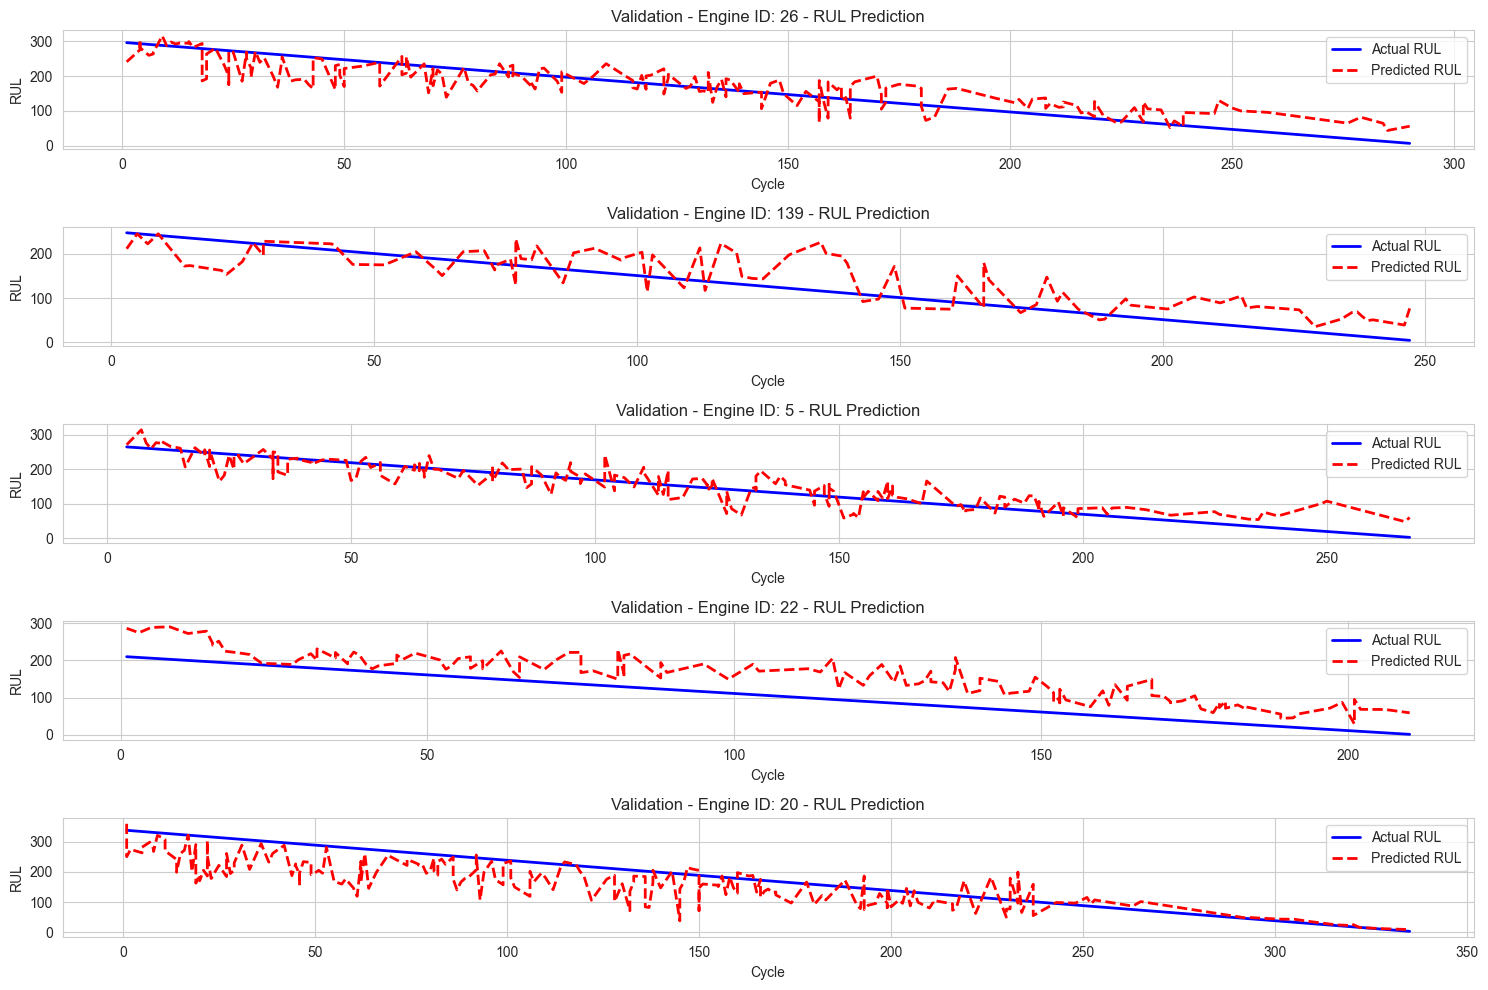


Visualization complete for Validation Set. Plots show actual vs. predicted RUL for sample engines.


In [11]:
# --- 7. Visualization of Predictions on Validation Set ---
# Select a few engines from the validation set to visualize their RUL predictions
num_engines_to_plot_val = 5
# Get engine_id from the original train_df using the indices of X_val
sample_engines_val = train_df.loc[X_val.index, 'engine_id'].sample(n=num_engines_to_plot_val, random_state=42).unique()

plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for i, engine_id in enumerate(sample_engines_val):
    # Get actual and predicted RUL for the selected engine from the validation set
    # Filter the original train_df to get all data for this engine_id
    engine_data = train_df[train_df['engine_id'] == engine_id].sort_values(by='cycle')
    
    # Ensure we only plot data that was part of the validation set by checking indices
    engine_val_data = engine_data[engine_data.index.isin(X_val.index)]
    
    if not engine_val_data.empty:
        # Predict RUL for the validation data of this specific engine
        engine_pred_rul = model.predict(engine_val_data[all_features])
        
        plt.subplot(num_engines_to_plot_val, 1, i + 1)
        plt.plot(engine_val_data['cycle'], engine_val_data['RUL'], label='Actual RUL', color='blue', linewidth=2)
        plt.plot(engine_val_data['cycle'], engine_pred_rul, label='Predicted RUL', color='red', linestyle='--', linewidth=2)
        plt.title(f'Validation - Engine ID: {engine_id} - RUL Prediction')
        plt.xlabel('Cycle')
        plt.ylabel('RUL')
        plt.legend()
        plt.grid(True)

plt.tight_layout()
# Save the validation plot
plt.savefig('rul_validation_predictions.png')
print('rul_validation_predictions plot saved successfully!')
plt.show()

print("\nVisualization complete for Validation Set. Plots show actual vs. predicted RUL for sample engines.")

In [12]:
# --- 8. Load and Preprocess Test Data ---
test_files = ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
rul_files = ['RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt']

all_test_dfs = []

print("\nLoading all test data sets and their RUL files...")
for i, test_file_name in enumerate(test_files):
    test_file_path = os.path.join(base_dir, test_file_name)
    rul_file_path = os.path.join(base_dir, rul_files[i])

    try:
        test_df_single = pd.read_csv(test_file_path, sep=' ', header=None)
        test_df_single.drop(columns=[26, 27], inplace=True)
        test_df_single.columns = columns
        
        # Load RUL for test data
        # The RUL file contains one RUL value per engine, in order of engine_id
        rul_df_single = pd.read_csv(rul_file_path, sep=' ', header=None)
        rul_df_single.drop(columns=[1], inplace=True) # Drop the extra empty column
        rul_df_single.columns = ['RUL_at_last_cycle'] # Rename for clarity
        
        # Add engine_id to rul_df_single based on its row index (assuming 1-based engine_id)
        rul_df_single['engine_id'] = rul_df_single.index + 1
        
        # Get the max cycle for each engine in this test_df_single
        max_cycles_test_engines = test_df_single.groupby('engine_id')['cycle'].max().reset_index()
        max_cycles_test_engines.rename(columns={'cycle': 'max_test_cycle'}, inplace=True)

        # Merge the RUL_at_last_cycle from rul_df_single to max_cycles_test_engines
        max_cycles_test_engines = pd.merge(max_cycles_test_engines, rul_df_single, on='engine_id', how='left')

        # Merge this combined RUL and max_cycle info back to the main test_df_single
        test_df_single = pd.merge(test_df_single, max_cycles_test_engines, on='engine_id', how='left')
        
        # Calculate RUL for each cycle in the test set
        # RUL at current cycle = RUL_at_last_cycle + (max_test_cycle - current_cycle)
        test_df_single['RUL'] = test_df_single['RUL_at_last_cycle'] + (test_df_single['max_test_cycle'] - test_df_single['cycle'])
        
        # Drop temporary columns
        test_df_single.drop(columns=['max_test_cycle', 'RUL_at_last_cycle'], inplace=True)
        
        all_test_dfs.append(test_df_single)
        print(f"Loaded {test_file_name} and {rul_files[i]} successfully. Test shape: {test_df_single.shape}")
    except FileNotFoundError:
        print(f"Error: Test file '{test_file_path}' or RUL file '{rul_file_path}' not found.")
        exit()
    except Exception as e:
        print(f"An error occurred while loading {test_file_name}: {e}")
        exit()

test_df = pd.concat(all_test_dfs, ignore_index=True)
print("\nAll test data combined and RUL calculated successfully.")
print(f"Combined test data shape: {test_df.shape}")
print(test_df[['engine_id', 'cycle', 'RUL']].head())

# Apply the same scaler (fitted on training data) to test features
test_df[features] = scaler.transform(test_df[features])
print("\nTest features scaled using the training data's MinMaxScaler.")

# Apply the same rolling window feature engineering to test data
print(f"\nAdding rolling window features to test data with window size = {window_size}...")
for col in sensor_cols:
    test_df[f'{col}_rolling_mean_{window_size}'] = test_df.groupby('engine_id')[col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    test_df[f'{col}_rolling_std_{window_size}'] = test_df.groupby('engine_id')[col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).std()
    )

test_df.dropna(inplace=True) # Drop NaNs resulting from rolling calculations
print(f"Shape after adding rolling features and dropping NaNs in test data: {test_df.shape}")


Loading all test data sets and their RUL files...
Loaded test_FD001.txt and RUL_FD001.txt successfully. Test shape: (13096, 27)
Loaded test_FD002.txt and RUL_FD002.txt successfully. Test shape: (33991, 27)
Loaded test_FD003.txt and RUL_FD003.txt successfully. Test shape: (16596, 27)
Loaded test_FD004.txt and RUL_FD004.txt successfully. Test shape: (41214, 27)

All test data combined and RUL calculated successfully.
Combined test data shape: (104897, 27)
   engine_id  cycle  RUL
0          1      1  142
1          1      2  141
2          1      3  140
3          1      4  139
4          1      5  138

Test features scaled using the training data's MinMaxScaler.

Adding rolling window features to test data with window size = 20...
Shape after adding rolling features and dropping NaNs in test data: (104638, 55)



Evaluating model on the Test Set...

Model Evaluation on Test Set:
Mean Absolute Error (MAE): 63.04
Root Mean Squared Error (RMSE): 76.63
rul_test_predictions plot saved successfully!


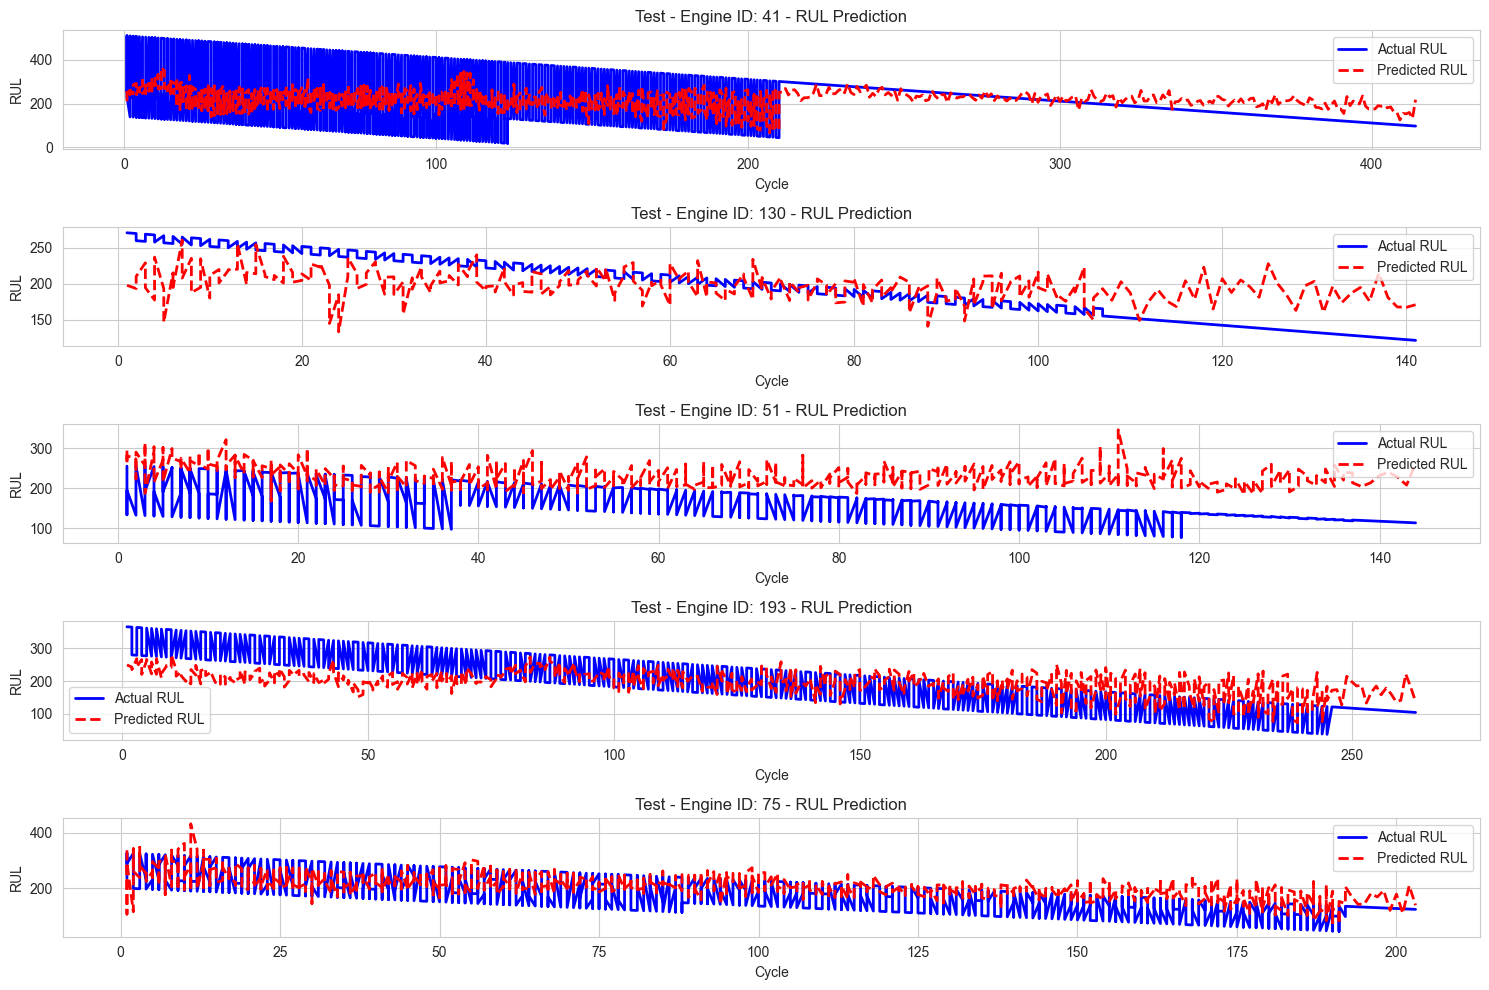


Visualization complete for Test Set. Plots show actual vs. predicted RUL for sample engines.


In [13]:
# --- 9. Model Evaluation on Test Set ---
X_test = test_df[all_features]
y_test = test_df['RUL']

print("\nEvaluating model on the Test Set...")
y_pred_test = model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nModel Evaluation on Test Set:")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.2f}")

# --- 10. Visualization of Predictions on Test Set ---
num_engines_to_plot_test = 5
# Get engine_id from the test_df itself for sampling
sample_engines_test = test_df['engine_id'].sample(n=num_engines_to_plot_test, random_state=42).unique()

plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for i, engine_id in enumerate(sample_engines_test):
    engine_data_test = test_df[test_df['engine_id'] == engine_id].sort_values(by='cycle')
    
    if not engine_data_test.empty:
        engine_pred_rul_test = model.predict(engine_data_test[all_features])
        
        plt.subplot(num_engines_to_plot_test, 1, i + 1)
        plt.plot(engine_data_test['cycle'], engine_data_test['RUL'], label='Actual RUL', color='blue', linewidth=2)
        plt.plot(engine_data_test['cycle'], engine_pred_rul_test, label='Predicted RUL', color='red', linestyle='--', linewidth=2)
        plt.title(f'Test - Engine ID: {engine_id} - RUL Prediction')
        plt.xlabel('Cycle')
        plt.ylabel('RUL')
        plt.legend()
        plt.grid(True)

plt.tight_layout()
# Save the test plot
plt.savefig('rul_test_predictions.png')
print('rul_test_predictions plot saved successfully!')
plt.show()

print("\nVisualization complete for Test Set. Plots show actual vs. predicted RUL for sample engines.")

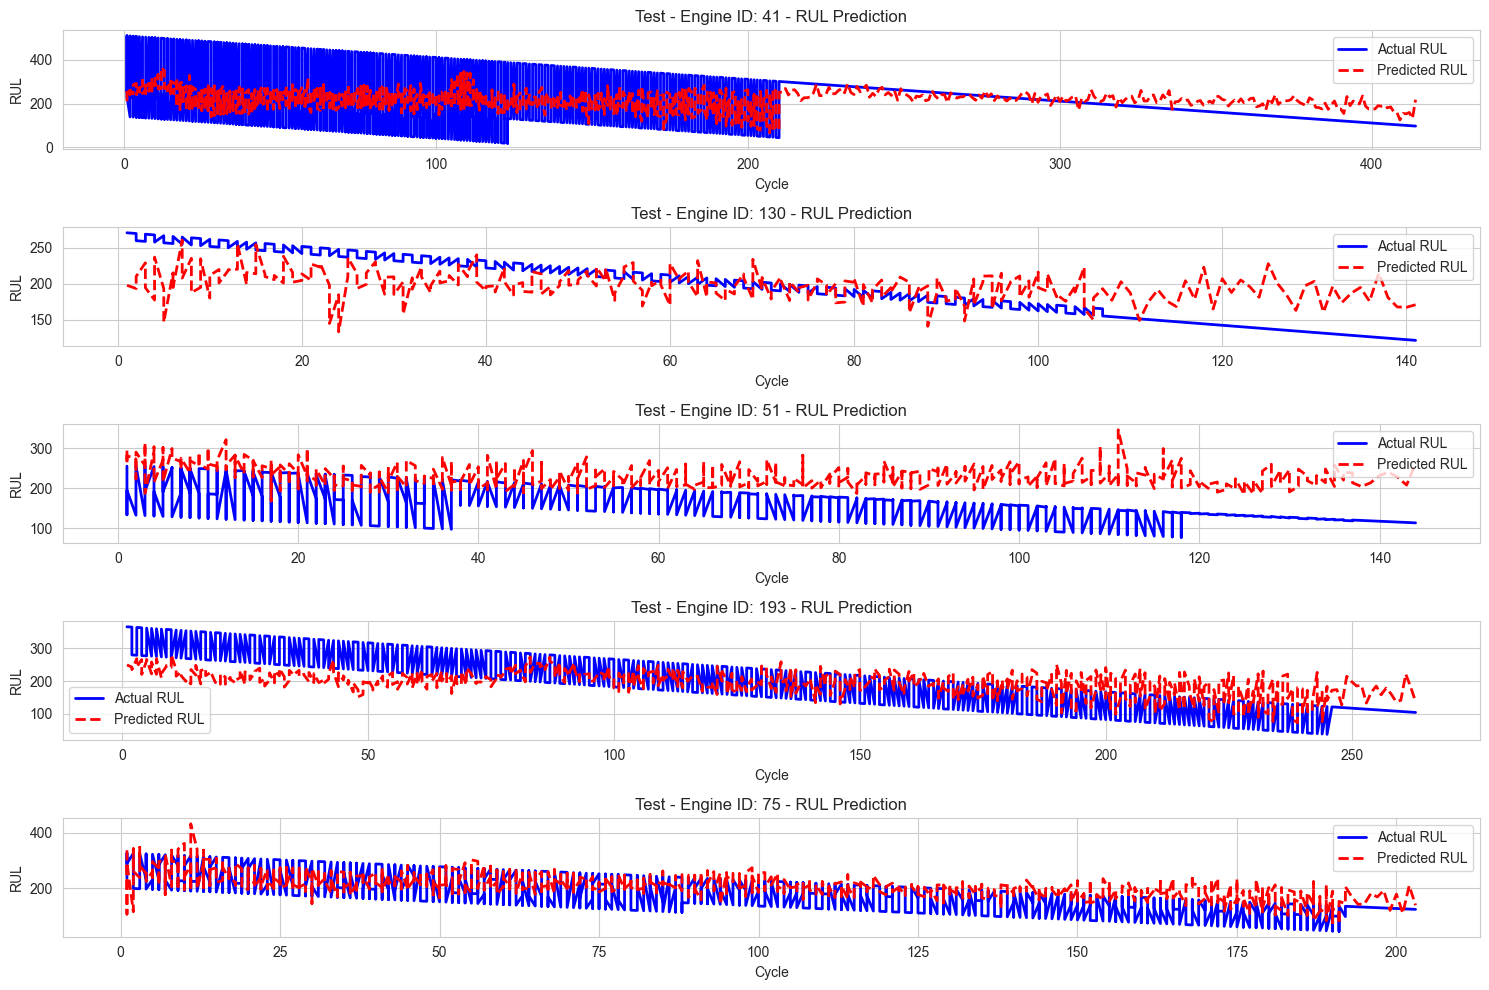


Visualization complete for Test Set. Plots show actual vs. predicted RUL for sample engines.


In [14]:
# --- 11. Visualization of Predictions on Test Set ---
num_engines_to_plot_test = 5

# Sample 5 unique engine IDs from the test set
sample_engines_test = test_df['engine_id'].sample(n=num_engines_to_plot_test, random_state=42).unique()

plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

for i, engine_id in enumerate(sample_engines_test):
    # Get actual and predicted RUL for this engine
    engine_data = test_df[test_df['engine_id'] == engine_id].sort_values(by='cycle')
    engine_pred_rul = model.predict(engine_data[all_features])

    plt.subplot(num_engines_to_plot_test, 1, i + 1)
    plt.plot(engine_data['cycle'], engine_data['RUL'], label='Actual RUL', color='blue', linewidth=2)
    plt.plot(engine_data['cycle'], engine_pred_rul, label='Predicted RUL', color='red', linestyle='--', linewidth=2)
    plt.title(f'Test - Engine ID: {engine_id} - RUL Prediction')
    plt.xlabel('Cycle')
    plt.ylabel('RUL')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('rul_test_predictions.png')
plt.show()

print("\nVisualization complete for Test Set. Plots show actual vs. predicted RUL for sample engines.")

## Explainable AI

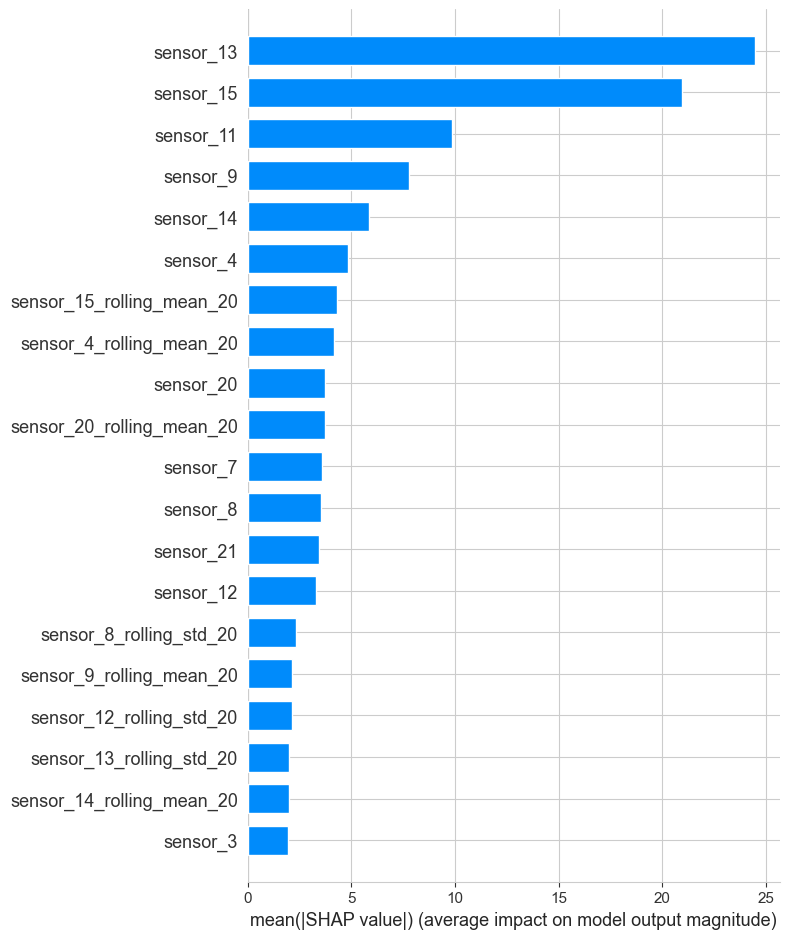

In [22]:
# !pip install shap seaborn matplotlib scikit-learn pandas

import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# --- 1. Train model ---
rf_model = RandomForestRegressor(n_estimators=5, random_state=42)
rf_model.fit(X_train, y_train)

# --- 2. Sample data for SHAP ---
X_train_sample = X_train.sample(100, random_state=42)

# --- 3. Compute SHAP values ---
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_sample)

# --- Plot settings ---
plot_width = 10
plot_height = 6

# --- 4. SHAP Summary Plot (Global Feature Importance) ---
plt.figure(figsize=(plot_width, plot_height))
plt.title("1. SHAP Summary Plot (Global Feature Importance)")
shap.summary_plot(shap_values, X_train_sample, feature_names=X_train_sample.columns, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

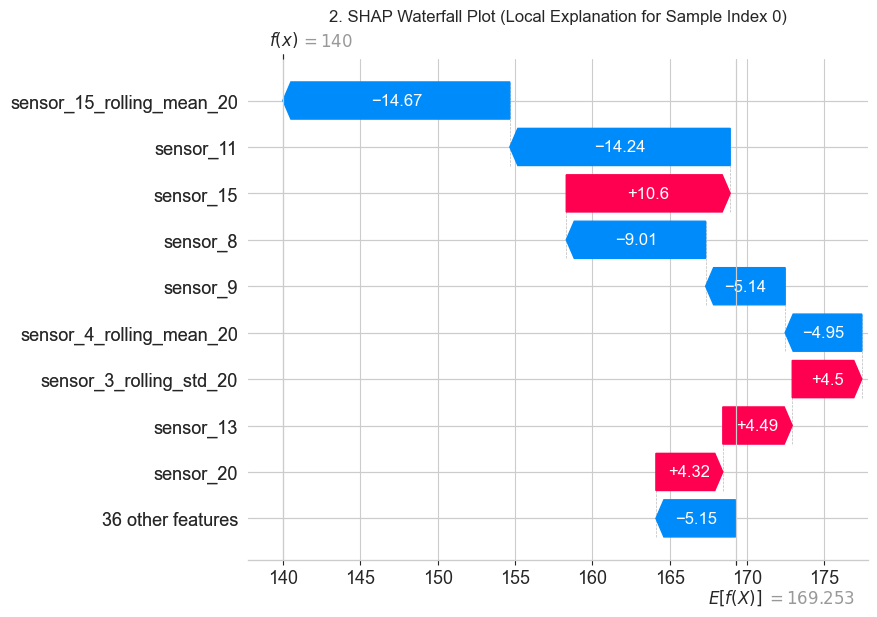

In [23]:
# --- 5. SHAP Waterfall Plot (Local Explanation) ---
idx = 0
plt.title("2. SHAP Waterfall Plot (Local Explanation for Sample Index 0)")
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[0],
    shap_values[idx],
    feature_names=X_train_sample.columns.tolist()
)

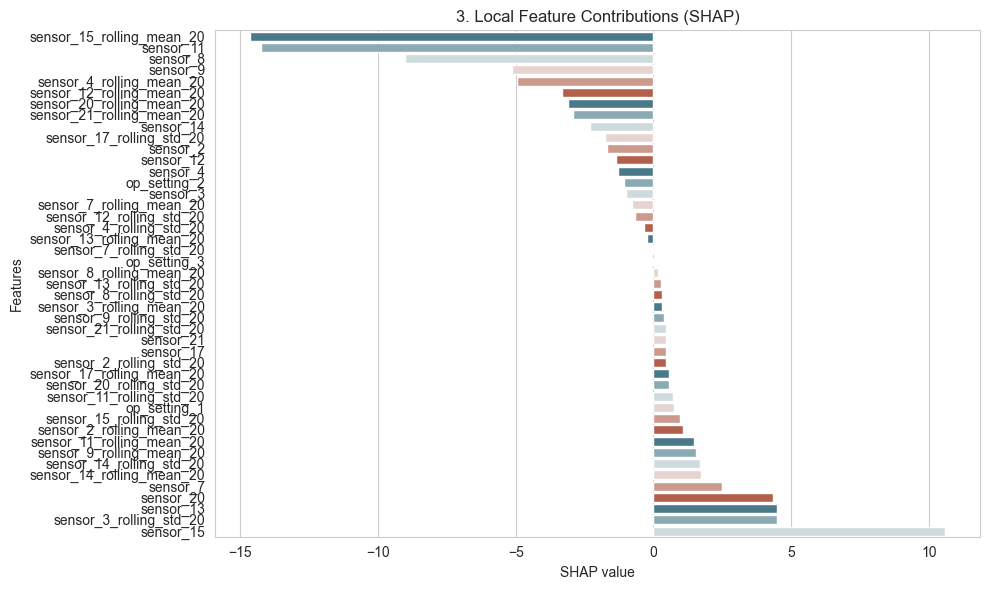

In [24]:
# --- 6. Custom Seaborn Barplot (SHAP Values Sorted) ---
sample_shap_series = pd.Series(shap_values[idx], index=X_train_sample.columns)
sample_shap_sorted = sample_shap_series.sort_values()
print('')
print('')
plt.figure(figsize=(plot_width, plot_height))
plt.title("3. Local Feature Contributions (SHAP)")
sns.barplot(
    x=sample_shap_sorted.values,
    y=sample_shap_sorted.index,
    orient="h",
    palette=sns.diverging_palette(220, 20, as_cmap=False)
)
plt.xlabel("SHAP value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

## 🧾 Summary: SHAP-Based Model Interpretation

This analysis employs **SHAP (SHapley Additive exPlanations)** to interpret the output of a `RandomForestRegressor` trained on turbofan engine sensor data. The interpretation is broken down into three key visualizations:

---

### 1. Global Feature Importance (SHAP Summary Plot)
- **Purpose**: Identifies which features are most influential *on average* across the dataset.
- **Inference**:
  - `sensor_13`, `sensor_15`, and `sensor_11` are the top contributors to model predictions.
  - Rolling statistics like `sensor_15_rolling_mean_20` also have significant impact, suggesting temporal trends are important.
- **Significance**: Helps with feature selection, domain understanding, and model simplification.

---

### 2. Local Explanation (SHAP Waterfall Plot)
- **Purpose**: Explains a *single prediction* by breaking it down into individual feature contributions.
- **Inference**:
  - Features like `sensor_15_rolling_mean_20` and `sensor_11` **decreased** the predicted value.
  - Others, such as `sensor_13` and `sensor_3_rolling_std_20`, **increased** the predicted value.
- **Significance**: Enables *instance-level interpretability*, useful for debugging, anomaly detection, and building trust in model behavior.

---

### 3. Seaborn Barplot (Sorted SHAP for a Single Instance)
- **Purpose**: Visualizes SHAP values for a single prediction using a standard horizontal bar chart.
- **Inference**:
  - Shows both the *magnitude* and *direction* of feature contributions to a specific output.
  - Easier to interpret for broader audiences compared to SHAP's custom visuals.
- **Significance**: Enhances *communication and transparency* of model decisions.

---

### 🔚 Conclusion
By combining **global** and **local** SHAP interpretations, we gain deep insights into both average model behavior and individual predictions. This dual perspective is particularly valuable for high-stakes applications like **predictive maintenance**, where interpretability can guide operational and strategic decisions.
